In [ ]:
# Gerekli kütüphaneleri içe aktar
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from imblearn.combine import SMOTETomek

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# GPU varsa kullan, yoksa CPU
device_name = tf.config.list_physical_devices('GPU')
if device_name:
    print(f"GPU kullanılıyor: {device_name[0]}")
else:
    print("GPU bulunamadı, CPU kullanılacak.")

GPU kullanılıyor: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
from google.colab import drive
import os
import zipfile
import numpy as np
from tqdm import tqdm
import gc
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ✅ Google Drive'ı bağla
drive.mount('/content/drive')

# ✅ ZIP dosyasının yolu ve çıkartılacak dizin
zip_path = "/content/drive/MyDrive/alzheimer.zip"
extract_dir = "/content/alzheimer_extracted"

# ✅ Daha önce çıkarıldıysa tekrar çıkarma
if not os.path.exists(extract_dir):
    print("📦 Zip dosyası çıkartılıyor...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("✅ Çıkartma işlemi tamamlandı.")
else:
    print("✅ ZIP dosyası daha önce çıkarılmış.")

# ✅ Klasör yolları
augmented_path = os.path.join(extract_dir, "AugmentedAlzheimerDataset")
original_path  = os.path.join(extract_dir, "OriginalDataset")

# ✅ Klasör var mı kontrol et
if not os.path.exists(augmented_path):
    raise FileNotFoundError(f"Train klasörü bulunamadı: {augmented_path}")
if not os.path.exists(original_path):
    raise FileNotFoundError(f"Test klasörü bulunamadı: {original_path}")

print("✅ Klasörler başarıyla bulundu ve tanımlandı.")

# ✅ Veriyi yükle
img_size = (128, 128)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
label_map = {cls: idx for idx, cls in enumerate(class_names)}

X_aug, y_aug = [], []

for cls in class_names:
    cls_path = os.path.join(augmented_path, cls)
    class_count = 0
    for img_name in tqdm(os.listdir(cls_path), desc=f"{cls}"):
        img_path = os.path.join(cls_path, img_name)
        try:
            img = load_img(img_path, target_size=img_size)
            img = img_to_array(img) / 255.0
            X_aug.append(img)
            y_aug.append(label_map[cls])
            class_count += 1
        except Exception as e:
            print(f"Hata ({img_name}): {e}")
    print(f"✅ {cls}: {class_count} görüntü yüklendi.")

X_aug = np.stack(X_aug, axis=0)
y_aug = np.array(y_aug)

gc.collect()

print("✅ Veri başarıyla yüklendi.")
print(f"X shape: {X_aug.shape}, y shape: {y_aug.shape}")


Mounted at /content/drive
📦 Zip dosyası çıkartılıyor...
✅ Çıkartma işlemi tamamlandı.
✅ Klasörler başarıyla bulundu ve tanımlandı.


MildDemented: 100%|██████████| 8960/8960 [00:05<00:00, 1630.59it/s]


✅ MildDemented: 8960 görüntü yüklendi.


ModerateDemented: 100%|██████████| 6464/6464 [00:03<00:00, 1676.80it/s]


✅ ModerateDemented: 6464 görüntü yüklendi.


NonDemented: 100%|██████████| 9600/9600 [00:05<00:00, 1663.32it/s]


✅ NonDemented: 9600 görüntü yüklendi.


VeryMildDemented: 100%|██████████| 8960/8960 [00:05<00:00, 1658.90it/s]


✅ VeryMildDemented: 8960 görüntü yüklendi.
✅ Veri başarıyla yüklendi.
X shape: (33984, 128, 128, 3), y shape: (33984,)


In [ ]:
from sklearn.model_selection import train_test_split

# İlk olarak eğitim + validasyon + test verisini ayır (test = %20)
X_temp, X_test, y_temp, y_test = train_test_split(X_aug, y_aug, test_size=0.2, stratify=y_aug, random_state=42)

# Eğitim ve doğrulama olarak böl (validation = %25 of kalan → %20 overall)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (20390, 128, 128, 3)
Val shape: (6797, 128, 128, 3)
Test shape: (6797, 128, 128, 3)


In [ ]:
from imblearn.combine import SMOTETomek

# Flatten
X_train_flat = X_train.reshape((X_train.shape[0], -1))

# SMOTETomek uygulama
smt = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smt.fit_resample(X_train_flat, y_train)

# Geriye reshape et (128, 128, 3)
X_train_resampled = X_train_resampled.reshape((-1, 128, 128, 3))

print("Yeni SMOTE sonrası train shape:", X_train_resampled.shape)


Yeni SMOTE sonrası train shape: (22618, 128, 128, 3)


In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train_resampled, num_classes=4)
y_val_cat   = to_categorical(y_val, num_classes=4)
y_test_cat  = to_categorical(y_test, num_classes=4)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.4530 - loss: 6.3707 - val_accuracy: 0.3344 - val_loss: 5.8795
Epoch 2/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6006 - loss: 4.6075 - val_accuracy: 0.5678 - val_loss: 3.8752
Epoch 3/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6463 - loss: 3.5088 - val_accuracy: 0.6098 - val_loss: 3.0213
Epoch 4/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6796 - loss: 2.7212 - val_accuracy: 0.6969 - val_loss: 2.3019
Epoch 5/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6991 - loss: 2.1776 - val_accuracy: 0.6843 - val_loss: 1.9446
Epoch 6/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7231 - loss: 1.7606 - val_accuracy: 0.7447 - val_loss: 1.5225
Epoch 7/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7377 - loss: 1.4897 - val_accuracy: 0.7552 - val_loss: 1.2973
Epoch 8/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7602 - loss: 1.2550 -

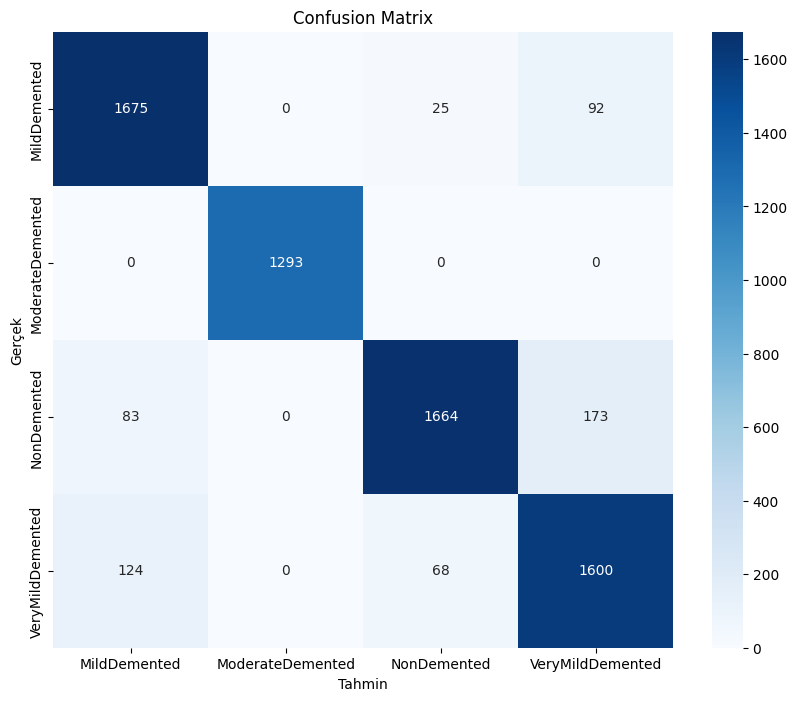

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2

def build_cnn_model(input_shape=(128, 128, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.4),

        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),

        Dense(4, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

# Modeli oluştur
model = build_cnn_model()

# EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Model eğitimi
history = model.fit(
    X_train_resampled, y_train_cat,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val_cat),
    callbacks=[early_stop],
    verbose=1
)

# Test seti üzerinde değerlendirme
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Sınıflandırma raporu
print(classification_report(y_true, y_pred_classes, target_names=class_names))


# === Classification report yüzdelik (% formatında) ===
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Dictionary formatında al
report_dict = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)

# DataFrame'e dönüştür ve yüzdelik formatına çevir
report_df = pd.DataFrame(report_dict).transpose()
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']] * 100

# Sadece sınıflara ait kısmı göster
print("\n=== Yüzdelik Formatlı Classification Report ===")
print(report_df.iloc[:-3][['precision', 'recall', 'f1-score']].round(2))

# Ortalama skorlar
accuracy = report_df.loc['accuracy']['precision'] * 100
macro_avg = report_df.loc['macro avg'][['precision', 'recall', 'f1-score']].round(2)
weighted_avg = report_df.loc['weighted avg'][['precision', 'recall', 'f1-score']].round(2)

print("\n=== Ortalama Sonuçlar ===")
print(f"Accuracy       : {accuracy:.2f}%")
print(f"Macro Avg      : Precision={macro_avg['precision']}%, Recall={macro_avg['recall']}%, F1={macro_avg['f1-score']}%")
print(f"Weighted Avg   : Precision={weighted_avg['precision']}%, Recall={weighted_avg['recall']}%, F1={weighted_avg['f1-score']}%")


# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.4409 - loss: 1.1639 - val_accuracy: 0.6938 - val_loss: 0.6604
Epoch 2/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.7093 - loss: 0.6343 - val_accuracy: 0.7834 - val_loss: 0.4780
Epoch 3/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8264 - loss: 0.4153 - val_accuracy: 0.8529 - val_loss: 0.3673
Epoch 4/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8966 - loss: 0.2547 - val_accuracy: 0.8789 - val_loss: 0.3015
Epoch 5/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9537 - loss: 0.1257 - val_accuracy: 0.9410 - val_loss: 0.1588
Epoch 6/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9721 - loss: 0.0743 - val_accuracy: 0.9444 - val_loss: 0.1686
Epoch 7/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9831 - loss: 0.0498 - val_accuracy: 0.9534 - val_loss: 0.1300
Epoch 8/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 7s 19

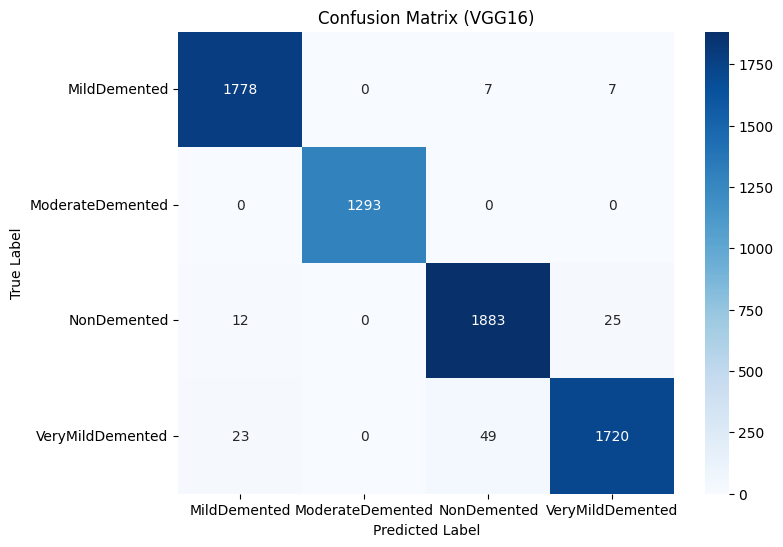

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# VGG16 base model
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# İlk birkaç katmanı dondur (örneğin ilk 15 katman)
for layer in base_model_vgg.layers[:15]:
    layer.trainable = False

# Katmanları ekle
x = base_model_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)

# Modeli oluştur
model_vgg = Model(inputs=base_model_vgg.input, outputs=predictions)
model_vgg.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Eğit
history_vgg = model_vgg.fit(
    X_train_resampled, y_train_cat,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val_cat),
    callbacks=[early_stop],
    verbose=1
)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Tahminleri al
y_pred_vgg = model_vgg.predict(X_test)
y_pred_classes_vgg = np.argmax(y_pred_vgg, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Sınıflandırma raporu
print("📊 Classification Report (VGG16):")
print(classification_report(y_true, y_pred_classes_vgg, target_names=class_names))

# === Yüzdelik Formatlı Metrikler ===
from sklearn.metrics import classification_report
import pandas as pd

report_dict = classification_report(y_true, y_pred_classes_vgg, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']] * 100

print("\n=== Yüzdelik Formatlı Classification Report (VGG16) ===")
print(report_df.iloc[:-3][['precision', 'recall', 'f1-score']].round(2))

accuracy = report_df.loc['accuracy']['precision'] * 100
macro_avg = report_df.loc['macro avg'][['precision', 'recall', 'f1-score']].round(2)
weighted_avg = report_df.loc['weighted avg'][['precision', 'recall', 'f1-score']].round(2)

print("\n=== Ortalama Sonuçlar (VGG16) ===")
print(f"Accuracy       : {accuracy:.2f}%")
print(f"Macro Avg      : Precision={macro_avg['precision']}%, Recall={macro_avg['recall']}%, F1={macro_avg['f1-score']}%")
print(f"Weighted Avg   : Precision={weighted_avg['precision']}%, Recall={weighted_avg['recall']}%, F1={weighted_avg['f1-score']}%")


# Confusion Matrix
cm_vgg = confusion_matrix(y_true, y_pred_classes_vgg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (VGG16)")
plt.show()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 62s 93ms/step - accuracy: 0.5413 - loss: 1.0047 - val_accuracy: 0.4117 - val_loss: 1.8592
Epoch 2/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.6844 - loss: 0.6968 - val_accuracy: 0.3996 - val_loss: 2.6666
Epoch 3/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.7233 - loss: 0.6089 - val_accuracy: 0.6290 - val_loss: 0.7866
Epoch 4/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.7585 - loss: 0.5444 - val_accuracy: 0.6800 - val_loss: 0.7299
Epoch 5/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.7876 - loss: 0.4901 - val_accuracy: 0.6551 - val_loss: 0.8641
Epoch 6/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.8089 - loss: 0.4438 - val_accuracy: 0.6357 - val_loss: 1.0666
Epoch 7/50
354/354 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.8279 - loss: 0.4005 - val_accuracy: 0.7219 - val_loss: 0.6663
Epoch 8/50
354/354 ━━━━━━━━━━━━━━━━━━━━

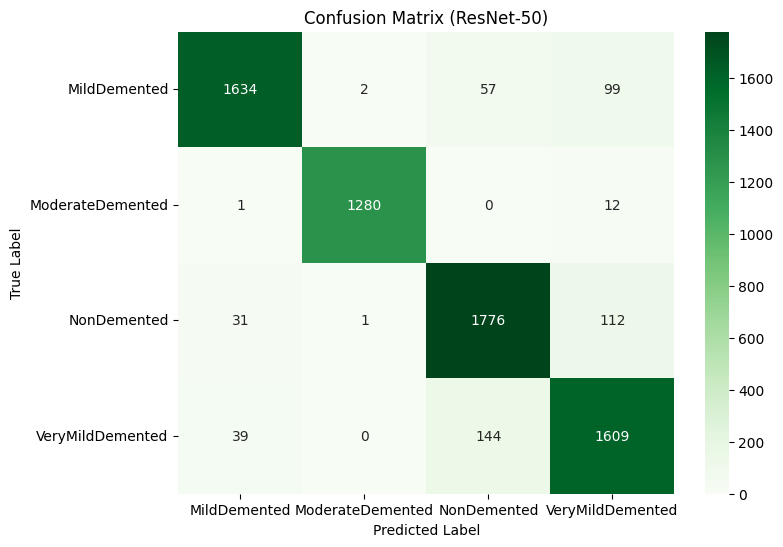

In [ ]:
from tensorflow.keras.applications import ResNet50

# ResNet50 base model
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# İlk katmanların dondurulması
for layer in base_model_resnet.layers[:100]:
    layer.trainable = False

# Ek katmanlar
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)

# Modeli oluştur
model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions)
model_resnet.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Eğit
history_resnet = model_resnet.fit(
    X_train_resampled, y_train_cat,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val_cat),
    callbacks=[early_stop],
    verbose=1
)


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Tahminleri al
y_pred_resnet = model_resnet.predict(X_test)
y_pred_classes_resnet = np.argmax(y_pred_resnet, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Sınıflandırma raporu
print("📊 Classification Report (ResNet-50):")
print(classification_report(y_true, y_pred_classes_resnet, target_names=class_names))

# === Yüzdelik Formatlı Metrikler ===
from sklearn.metrics import classification_report
import pandas as pd

report_dict_resnet = classification_report(y_true, y_pred_classes_resnet, target_names=class_names, output_dict=True)
report_df_resnet = pd.DataFrame(report_dict_resnet).transpose()
report_df_resnet[['precision', 'recall', 'f1-score']] = report_df_resnet[['precision', 'recall', 'f1-score']] * 100

print("\n=== Yüzdelik Formatlı Classification Report (ResNet-50) ===")
print(report_df_resnet.iloc[:-3][['precision', 'recall', 'f1-score']].round(2))

accuracy_resnet = report_df_resnet.loc['accuracy']['precision'] * 100
macro_avg_resnet = report_df_resnet.loc['macro avg'][['precision', 'recall', 'f1-score']].round(2)
weighted_avg_resnet = report_df_resnet.loc['weighted avg'][['precision', 'recall', 'f1-score']].round(2)

print("\n=== Ortalama Sonuçlar (ResNet-50) ===")
print(f"Accuracy       : {accuracy_resnet:.2f}%")
print(f"Macro Avg      : Precision={macro_avg_resnet['precision']}%, Recall={macro_avg_resnet['recall']}%, F1={macro_avg_resnet['f1-score']}%")
print(f"Weighted Avg   : Precision={weighted_avg_resnet['precision']}%, Recall={weighted_avg_resnet['recall']}%, F1={weighted_avg_resnet['f1-score']}%")


# Confusion Matrix
cm_resnet = confusion_matrix(y_true, y_pred_classes_resnet)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (ResNet-50)")
plt.show()


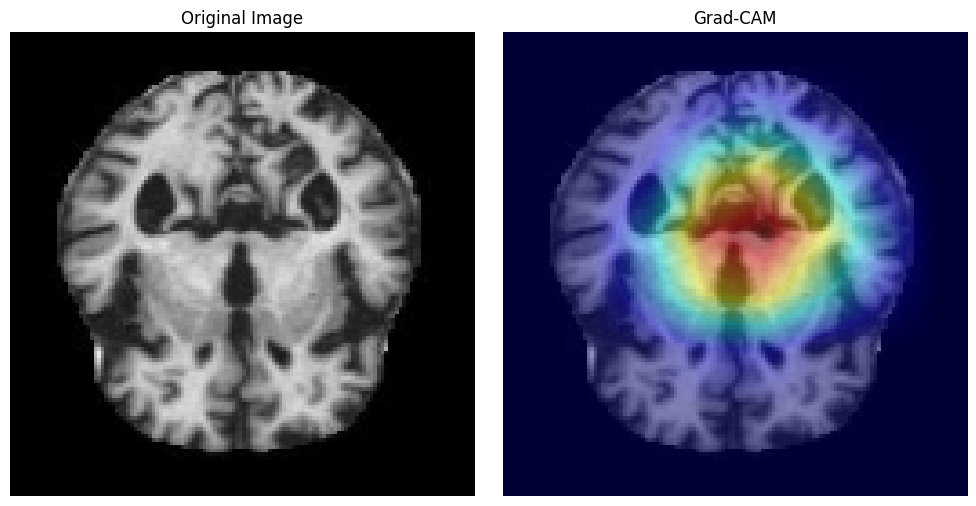

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --- Grad-CAM hesaplama ve görselleştirme ---
def gradcam_visualize(img_path, model, last_conv_layer_name='block5_conv3', img_size=(128, 128), alpha=0.4):
    # Görseli yükle ve hazırla
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Grad-CAM modeli
    grad_model = Model(inputs=model.inputs,
                       outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)

    # Görseli göster
    heatmap = cv2.resize(heatmap.numpy(), img_size)
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    original = cv2.imread(img_path)
    original = cv2.resize(original, img_size)
    superimposed_img = cv2.addWeighted(original, 1 - alpha, heatmap_color, alpha, 0)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Örnek kullanım
img_path = '/content/drive/MyDrive/AlzheimerData/OriginalDataset/ModerateDemented/moderateDem0.jpg'
gradcam_visualize(img_path, model_vgg)



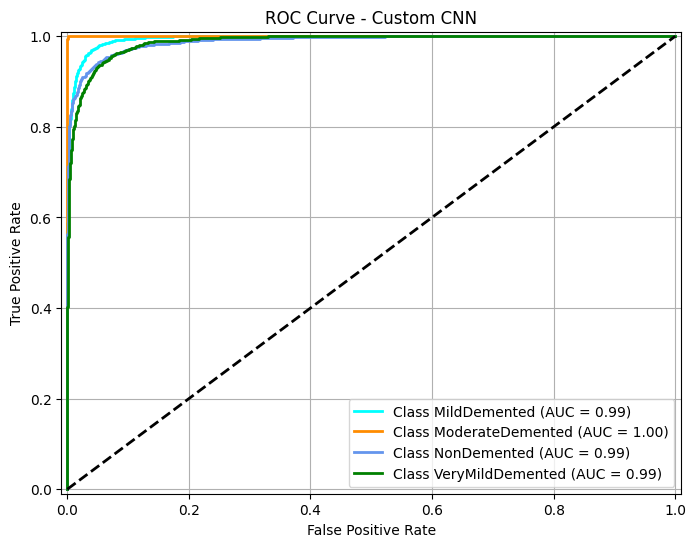

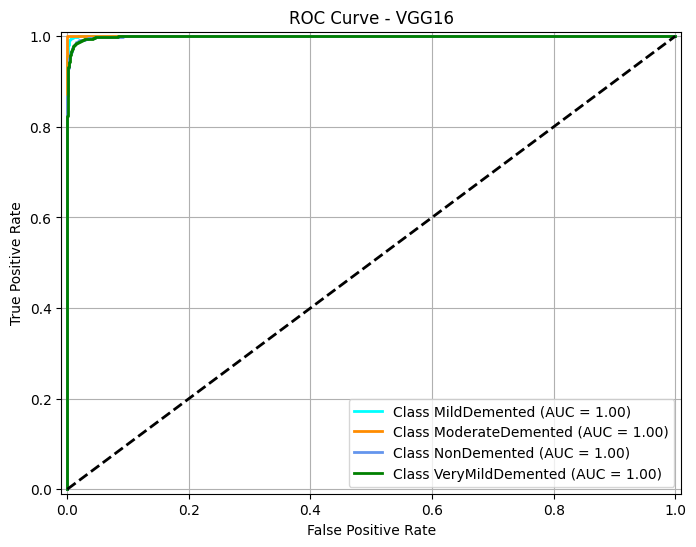

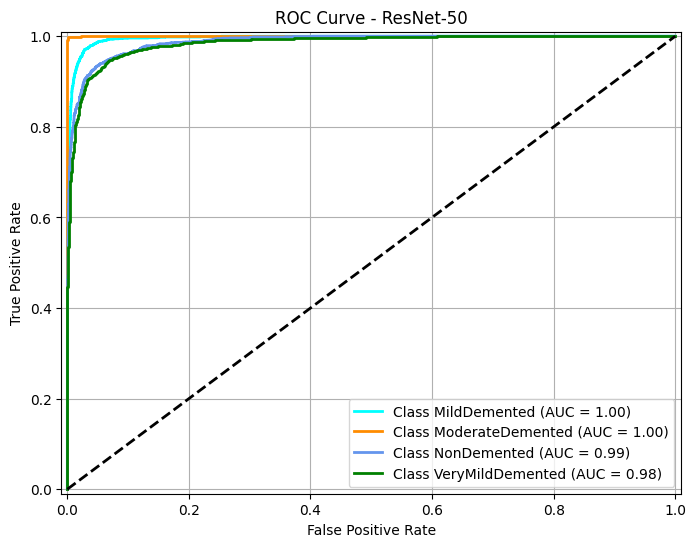

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Sınıf sayısı
n_classes = len(class_names)

# Etiketleri one-hot forma getir (zaten öyleyse gerek yok)
y_test_bin = y_test_cat  # zaten categorical

def plot_multiclass_roc(y_true_bin, y_score, model_name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Mikro ortalama (opsiyonel)
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Çizim
    plt.figure(figsize=(8, 6))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# ROC çizimleri
plot_multiclass_roc(y_test_cat, y_pred, "Custom CNN")
plot_multiclass_roc(y_test_cat, y_pred_vgg, "VGG16")
plot_multiclass_roc(y_test_cat, y_pred_resnet, "ResNet-50")
